In [1]:
import os

import psycopg2 as psycopg
import pandas as pd
import mlflow
from catboost import CatBoostClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

TABLE_NAME = 'clean_users_churn'
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

EXPERIMENT_NAME = 'churn_ujhmaster'
RUN_NAME = "feature_selection"
REGISTRY_MODEL_NAME = 'churn_model_ujhmaster_autofeat'
FS_ASSETS = "fs_assets" 

In [40]:
connection = {"sslmode": "require", "target_session_attrs": "read-write"}
postgres_credentials = {
    "host": os.environ.get("DB_DESTINATION_HOST"), 
    "port": os.environ.get("DB_DESTINATION_PORT"),
    "dbname": os.environ.get("DB_DESTINATION_NAME"),
    "user": os.environ.get("DB_DESTINATION_USER"),
    "password": os.environ.get("DB_DESTINATION_PASSWORD"),
}
assert all([var_value != "" for var_value in list(postgres_credentials.values())])

connection.update(postgres_credentials)
with psycopg.connect(**connection) as conn:

    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")
        data = cur.fetchall()
        columns = [col[0] for col in cur.description]

df = pd.DataFrame(data, columns=columns)

In [41]:
df.columns

Index(['id', 'customer_id', 'begin_date', 'end_date', 'type',
       'paperless_billing', 'payment_method', 'monthly_charges',
       'total_charges', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'gender', 'senior_citizen', 'partner', 'dependents', 'multiple_lines',
       'target'],
      dtype='object')

In [48]:
features = ['type',
       'paperless_billing', 'payment_method', 'monthly_charges',
       'total_charges', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'gender', 'senior_citizen', 'partner', 'dependents', 'multiple_lines']
target = ['target']

In [49]:
from sklearn.model_selection import train_test_split

split_column = "begin_date"
test_size = 0.2

#df = df.sort_values(by=[split_column])
#df = df.drop(columns="begin_date")

X_train, X_test, y_train, y_test = train_test_split(
    df[features],
    df[target],
    test_size=test_size,
    shuffle=False,
)
X_train.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines
0,One year,No,Credit card (automatic),100.35,5681.10,Fiber optic,No,No,Yes,No,Yes,Yes,Male,0,Yes,No,Yes
1,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.30,Fiber optic,No,Yes,Yes,No,Yes,Yes,Male,0,No,No,Yes
2,Month-to-month,Yes,Electronic check,105.50,2686.05,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Male,0,No,No,No
3,Two year,No,Credit card (automatic),113.25,7895.15,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Female,0,Yes,Yes,Yes
4,Two year,No,Bank transfer (automatic),106.70,7382.25,Fiber optic,Yes,No,Yes,No,Yes,Yes,Male,0,No,Yes,Yes


In [52]:
num_columns = X_train.select_dtypes(include=['float']).columns.to_list()
num_columns

['monthly_charges', 'total_charges']

In [55]:
potential_binary_features =  X_train[features].nunique() == 2
binary_features = X_train[potential_binary_features[potential_binary_features].index].columns.to_list()
cat_features = X_train[potential_binary_features[~potential_binary_features].index].columns.to_list()
cat_features

['type', 'payment_method', 'monthly_charges', 'total_charges']

In [58]:
date_features = ['begin_date']
cat_features = ['type', 'payment_method']

In [59]:
cat_features

['type', 'payment_method']

In [60]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder, 
    SplineTransformer, 
    QuantileTransformer, 
    RobustScaler,
    PolynomialFeatures,
    KBinsDiscretizer,
    Binarizer
)

n_knots = 3
degree_spline = 4
n_quantiles=100
degree = 2
n_bins = 5
encode = 'ordinal'
strategy = 'uniform'
subsample = None

encoder_spl = SplineTransformer(n_knots=n_knots,degree=degree_spline)
encoder_q   = QuantileTransformer(n_quantiles=n_quantiles)
encoder_rb  = RobustScaler()
encoder_pol = PolynomialFeatures(degree=degree)
encoder_kbd = KBinsDiscretizer(n_bins=n_bins, encode=encode, strategy=strategy, subsample=subsample)
encoder_oh  = OneHotEncoder(
    categories="auto",
    drop="first",
    sparse_output=False,
    max_categories=10,
    handle_unknown="ignore"
    )

transformer = ColumnTransformer(transformers=[
    #('spl', encoder_spl, num_columns), 
    #('q', encoder_q, num_columns), 
    #('rb', encoder_rb, num_columns), 
    ('pol', encoder_pol, num_columns), 
    #('kbd', encoder_kbd, num_columns),
    ('cat', encoder_oh, cat_features),
    ('bin',encoder_oh,binary_features)
], n_jobs=-1)

encoded_features = transformer.fit_transform(X_train)
encoded_features = pd.DataFrame(encoded_features,columns=transformer.get_feature_names_out())
encoded_features.head()

,pol__1,pol__monthly_charges,pol__total_charges,pol__monthly_charges^2,pol__monthly_charges total_charges,pol__total_charges^2,cat__type_One year,cat__type_Two year,cat__payment_method_Credit card (automatic),cat__payment_method_Electronic check,...,bin__online_backup_Yes,bin__device_protection_Yes,bin__tech_support_Yes,bin__streaming_tv_Yes,bin__streaming_movies_Yes,bin__gender_Male,bin__senior_citizen_1,bin__partner_Yes,bin__dependents_Yes,bin__multiple_lines_Yes
0,1.0,100.35,5681.10,10070.1225,570098.3850,3.227490e+07,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0
1,1.0,103.70,5036.30,10753.6900,522264.3100,2.536432e+07,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
2,1.0,105.50,2686.05,11130.2500,283378.2750,7.214865e+06,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
3,1.0,113.25,7895.15,12825.5625,894125.7375,6.233339e+07,0.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
4,1.0,106.70,7382.25,11384.8900,787686.0750,5.449762e+07,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0


In [61]:
encoded_features.columns

Index(['pol__1', 'pol__monthly_charges', 'pol__total_charges',
       'pol__monthly_charges^2', 'pol__monthly_charges total_charges',
       'pol__total_charges^2', 'cat__type_One year', 'cat__type_Two year',
       'cat__payment_method_Credit card (automatic)',
       'cat__payment_method_Electronic check',
       'cat__payment_method_Mailed check', 'bin__paperless_billing_Yes',
       'bin__internet_service_Fiber optic', 'bin__online_security_Yes',
       'bin__online_backup_Yes', 'bin__device_protection_Yes',
       'bin__tech_support_Yes', 'bin__streaming_tv_Yes',
       'bin__streaming_movies_Yes', 'bin__gender_Male',
       'bin__senior_citizen_1', 'bin__partner_Yes', 'bin__dependents_Yes',
       'bin__multiple_lines_Yes'],
      dtype='object')

In [64]:
from mlxtend.feature_selection import SequentialFeatureSelector

estimator = RandomForestClassifier(n_estimators=300,max_depth=3)

sfs = SequentialFeatureSelector(
    estimator,
    cv=2,
    floating=False,
    k_features=10, 
    forward=True,
    scoring='roc_auc',
    n_jobs=-1
)
sfs = sfs.fit(encoded_features, y_train)
top_sfs = sfs.k_feature_names_
top_sfs

/home/mle-user/mle_projects/mle-mlflow/.venv_mlflow/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/mle-user/mle_projects/mle-mlflow/.venv_mlflow/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/mle-user/mle_projects/mle-mlflow/.venv_mlflow/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/mle-user/mle_projects/mle-mlflow/.venv_mlflow/lib/python3.10/site-packages/s

('pol__monthly_charges',
 'pol__total_charges',
 'cat__type_One year',
 'cat__type_Two year',
 'cat__payment_method_Credit card (automatic)',
 'bin__paperless_billing_Yes',
 'bin__internet_service_Fiber optic',
 'bin__online_security_Yes',
 'bin__tech_support_Yes',
 'bin__senior_citizen_1')

In [68]:
sfs_df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
os.makedirs(FS_ASSETS,exist_ok=True)

sfs_df.to_csv(f"{FS_ASSETS}/sfs.csv")
sfs_df

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(2,)","[0.6594434587814784, 0.6716708422161016]",0.665557,"(pol__total_charges,)",0.026305,0.006114,0.006114
2,"(1, 2)","[0.7990193915308549, 0.8148461530481511]",0.806933,"(pol__monthly_charges, pol__total_charges)",0.034049,0.007913,0.007913
3,"(1, 2, 7)","[0.8142752478614286, 0.8269675655768741]",0.820621,"(pol__monthly_charges, pol__total_charges, cat...",0.027305,0.006346,0.006346
4,"(1, 2, 6, 7)","[0.8233574435003134, 0.8417525118134334]",0.832555,"(pol__monthly_charges, pol__total_charges, cat...",0.039574,0.009198,0.009198
5,"(1, 2, 6, 7, 12)","[0.8286735341490038, 0.8434003625725534]",0.836037,"(pol__monthly_charges, pol__total_charges, cat...",0.031682,0.007363,0.007363
6,"(1, 2, 6, 7, 11, 12)","[0.8314217816950489, 0.8443884894885082]",0.837905,"(pol__monthly_charges, pol__total_charges, cat...",0.027896,0.006483,0.006483
7,"(1, 2, 6, 7, 8, 11, 12)","[0.8334166135620014, 0.845357813464461]",0.839387,"(pol__monthly_charges, pol__total_charges, cat...",0.025689,0.005971,0.005971
8,"(1, 2, 6, 7, 8, 11, 12, 20)","[0.8336275180371997, 0.8471421476329044]",0.840385,"(pol__monthly_charges, pol__total_charges, cat...",0.029074,0.006757,0.006757
9,"(1, 2, 6, 7, 8, 11, 12, 13, 20)","[0.8354834774189445, 0.847811921323312]",0.841648,"(pol__monthly_charges, pol__total_charges, cat...",0.026523,0.006164,0.006164
10,"(1, 2, 6, 7, 8, 11, 12, 13, 16, 20)","[0.8354834774189445, 0.8494857071720896]",0.842485,"(pol__monthly_charges, pol__total_charges, cat...",0.030123,0.007001,0.007001


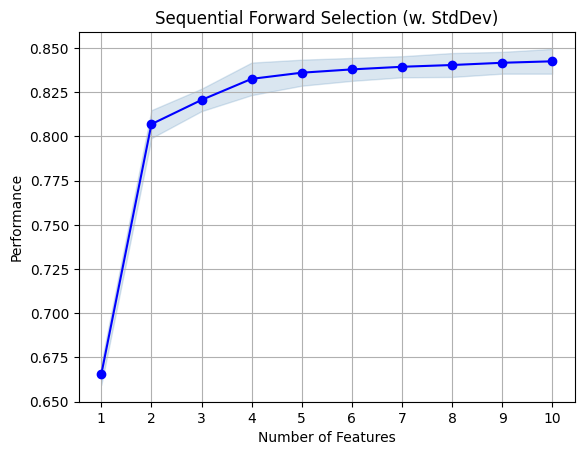

<Figure size 640x480 with 0 Axes>

In [70]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

plt.savefig(f"{FS_ASSETS}/sfs.png") 

In [74]:
sbs = SequentialFeatureSelector(
    estimator,
    cv=2,
    floating=False,
    k_features=10, 
    forward=False,
    scoring='roc_auc',
    n_jobs=-1
)
sbs = sbs.fit(encoded_features, y_train)
top_sbs = sbs.k_feature_names_
top_sbs

/home/mle-user/mle_projects/mle-mlflow/.venv_mlflow/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/mle-user/mle_projects/mle-mlflow/.venv_mlflow/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/mle-user/mle_projects/mle-mlflow/.venv_mlflow/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/mle-user/mle_projects/mle-mlflow/.venv_mlflow/lib/python3.10/site-packages/s

('pol__monthly_charges^2',
 'pol__total_charges^2',
 'cat__type_One year',
 'cat__type_Two year',
 'cat__payment_method_Credit card (automatic)',
 'cat__payment_method_Mailed check',
 'bin__internet_service_Fiber optic',
 'bin__online_security_Yes',
 'bin__tech_support_Yes',
 'bin__senior_citizen_1')

In [75]:
sbs_df = pd.DataFrame.from_dict(sbs.get_metric_dict()).T 
sbs_df.to_csv(f"{FS_ASSETS}/sbs.csv")
sbs_df

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
24,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.8364348188363004, 0.8458972633293393]",0.841166,"(pol__1, pol__monthly_charges, pol__total_char...",0.020357,0.004731,0.004731
23,"(0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.8366914733591957, 0.8489245366696233]",0.842808,"(pol__1, pol__monthly_charges, pol__monthly_ch...",0.026317,0.006117,0.006117
22,"(0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.8371794738679621, 0.8485958094082131]",0.842888,"(pol__1, pol__monthly_charges, pol__monthly_ch...",0.02456,0.005708,0.005708
21,"(0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 1...","[0.8359841321962231, 0.8505432104528786]",0.843264,"(pol__1, pol__monthly_charges, pol__monthly_ch...",0.031321,0.00728,0.00728
20,"(0, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, ...","[0.8370133460351905, 0.850739668757035]",0.843877,"(pol__1, pol__monthly_charges^2, pol__monthly_...",0.02953,0.006863,0.006863
19,"(0, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 16, ...","[0.8367407925595497, 0.8512671236429464]",0.844004,"(pol__1, pol__monthly_charges^2, pol__monthly_...",0.031251,0.007263,0.007263
18,"(0, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 16, ...","[0.837653522234523, 0.8511857522991455]",0.84442,"(pol__1, pol__monthly_charges^2, pol__monthly_...",0.029112,0.006766,0.006766
17,"(0, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 16, ...","[0.8370928407989192, 0.851185428110525]",0.844139,"(pol__1, pol__monthly_charges^2, pol__monthly_...",0.030318,0.007046,0.007046
16,"(0, 3, 5, 6, 7, 8, 10, 11, 12, 13, 14, 16, 17,...","[0.8377476180773039, 0.8516243795029799]",0.844686,"(pol__1, pol__monthly_charges^2, pol__total_ch...",0.029853,0.006938,0.006938
15,"(0, 3, 5, 6, 7, 8, 10, 11, 12, 13, 14, 16, 17,...","[0.8381379535906325, 0.8509727603753326]",0.844555,"(pol__1, pol__monthly_charges^2, pol__total_ch...",0.027612,0.006417,0.006417


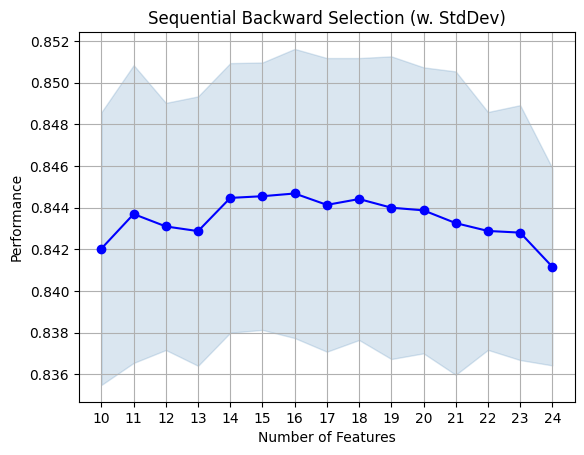

<Figure size 640x480 with 0 Axes>

In [82]:
fig = plot_sfs(sbs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Backward Selection (w. StdDev)')
plt.grid()
plt.show()
plt.savefig(os.path.join(FS_ASSETS, 'sbs'))


In [77]:
interc_features = list(set(top_sbs) & set(top_sfs))
union_features = list(set(top_sbs) | set(top_sfs))

In [79]:
union_features

['cat__payment_method_Credit card (automatic)',
 'cat__payment_method_Mailed check',
 'pol__monthly_charges',
 'bin__paperless_billing_Yes',
 'pol__total_charges^2',
 'bin__tech_support_Yes',
 'bin__senior_citizen_1',
 'bin__online_security_Yes',
 'pol__total_charges',
 'bin__internet_service_Fiber optic',
 'pol__monthly_charges^2',
 'cat__type_One year',
 'cat__type_Two year']

In [78]:
interc_features

['cat__payment_method_Credit card (automatic)',
 'bin__online_security_Yes',
 'bin__internet_service_Fiber optic',
 'cat__type_One year',
 'cat__type_Two year',
 'bin__tech_support_Yes',
 'bin__senior_citizen_1']

In [80]:
os.environ['MLFLOW_S3_ENDPOINT_URL']='https://storage.yandexcloud.net'
os.environ['AWS_BUCKET_NAME']=os.environ.get("S3_BUCKET_NAME")

TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000
mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

In [81]:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=f"{RUN_NAME}_intersection_and_union", experiment_id=experiment_id) as run:
    run_id = run.info.run_id
   
    mlflow.log_artifacts(FS_ASSETS) 

2024-09-10 21:00:55,257 INFO: Found credentials in environment variables.


In [94]:
model = RandomForestClassifier(n_estimators=300)

model.fit(encoded_features[union_features], y_train)

/home/mle-user/mle_projects/mle-mlflow/.venv_mlflow/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(n_estimators=300)

In [95]:
X_val_tr = transformer.transform(X_test)
X_val_tr = pd.DataFrame(X_val_tr,columns=transformer.get_feature_names_out())
X_val_tr = X_val_tr[union_features]

prediction = model.predict(X_val_tr)
probas = model.predict_proba(X_val_tr)

In [96]:
from sklearn.metrics import f1_score,roc_auc_score,recall_score,confusion_matrix,log_loss,precision_score

# заведите словарь со всеми метриками
metrics = {}
y_val = y_test
# посчитайте метрики из модуля sklearn.metrics
# err_1 — ошибка первого рода
# err_2 — ошибка второго рода
_, err1, _, err2 = confusion_matrix(y_val,prediction,normalize='all').ravel()
auc = roc_auc_score(y_val,probas[:,1])
precision = precision_score(y_val,prediction)
recall = recall_score(y_val,prediction)
f1 = f1_score(y_val,prediction)
logloss = log_loss(y_val,prediction)

# запишите значения метрик в словарь
metrics["err1"] = err1
metrics["err2"] = err2
metrics["auc"] = auc
metrics["precision"] = precision
metrics["recall"] = recall
metrics["f1"] = f1
metrics["logloss"] = logloss

print(metrics)

{'err1': 0.0695528743789922, 'err2': 0.12207239176721078, 'auc': 0.8097442354848413, 'precision': 0.6370370370370371, 'recall': 0.450261780104712, 'f1': 0.5276073619631901, 'logloss': 7.878953331332919}


In [97]:
RUN_NAME = "forest_sm_union"
DIR_PATH = 'dataframe'
REGISTRY_MODEL_NAME = "churn_model_ujhmaster"

pip_requirements = "./requirements.txt"
metadata = {'model_type': 'monthly'}
input_example = X_val_tr[:10]
signature = mlflow.models.infer_signature(X_val_tr, prediction)
EXPERIMENT_NAME = 'feature_selection_union'
experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id
    
    # логируем метрики эксперимента
    mlflow.log_metrics(metrics)
    
    # логируем модель
    model_info = mlflow.sklearn.log_model( 
            sk_model=model, 
			pip_requirements=pip_requirements,
            signature=signature, 
            metadata=metadata,
            input_example=input_example, 
            artifact_path='models', 
            registered_model_name=REGISTRY_MODEL_NAME,
            await_registration_for=60
		)

Successfully registered model 'churn_model_ujhmaster'.
2024/09/10 21:31:32 INFO mlflow.tracking._model_registry.client: Waiting up to 60 seconds for model version to finish creation. Model name: churn_model_ujhmaster, version 1
Created version '1' of model 'churn_model_ujhmaster'.


In [98]:
model_interc_features = RandomForestClassifier(n_estimators=300)
model_interc_features.fit(encoded_features[interc_features], y_train)
X_val_tr = transformer.transform(X_test)
X_val_tr = pd.DataFrame(X_val_tr,columns=transformer.get_feature_names_out())
X_val_tr = X_val_tr[interc_features]

prediction = model_interc_features.predict(X_val_tr)
probas = model_interc_features.predict_proba(X_val_tr)

_, err1, _, err2 = confusion_matrix(y_val,prediction,normalize='all').ravel()
auc = roc_auc_score(y_val,probas[:,1])
precision = precision_score(y_val,prediction)
recall = recall_score(y_val,prediction)
f1 = f1_score(y_val,prediction)
logloss = log_loss(y_val,prediction)

# запишите значения метрик в словарь
metrics["err1"] = err1
metrics["err2"] = err2
metrics["auc"] = auc
metrics["precision"] = precision
metrics["recall"] = recall
metrics["f1"] = f1
metrics["logloss"] = logloss

print(metrics)

RUN_NAME = "forest_sm_interc"
DIR_PATH = 'dataframe'
REGISTRY_MODEL_NAME = "churn_model_ujhmaster"

pip_requirements = "./requirements.txt"
metadata = {'model_type': 'monthly'}
input_example = X_val_tr[:10]
signature = mlflow.models.infer_signature(X_val_tr, prediction)
EXP_NAME = 'feature_selection_intersection'
experiment_id = mlflow.create_experiment(EXP_NAME)

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id
    
    # логируем метрики эксперимента
    mlflow.log_metrics(metrics)
    
    # логируем модель
    model_info = mlflow.sklearn.log_model( 
            sk_model=model_interc_features, 
			pip_requirements=pip_requirements,
            signature=signature, 
            metadata=metadata,
            input_example=input_example, 
            artifact_path='models', 
            registered_model_name=REGISTRY_MODEL_NAME,
            await_registration_for=60
		)
    
run_id

/home/mle-user/mle_projects/mle-mlflow/.venv_mlflow/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


{'err1': 0.036905606813342796, 'err2': 0.0482611781405252, 'auc': 0.7709704471418303, 'precision': 0.5666666666666667, 'recall': 0.17801047120418848, 'f1': 0.2709163346613546, 'logloss': 9.36265233528522}


Registered model 'churn_model_ujhmaster' already exists. Creating a new version of this model...
2024/09/10 21:33:16 INFO mlflow.tracking._model_registry.client: Waiting up to 60 seconds for model version to finish creation. Model name: churn_model_ujhmaster, version 2
Created version '2' of model 'churn_model_ujhmaster'.


'e7ca3a48fd9444c6963f069b1a566956'